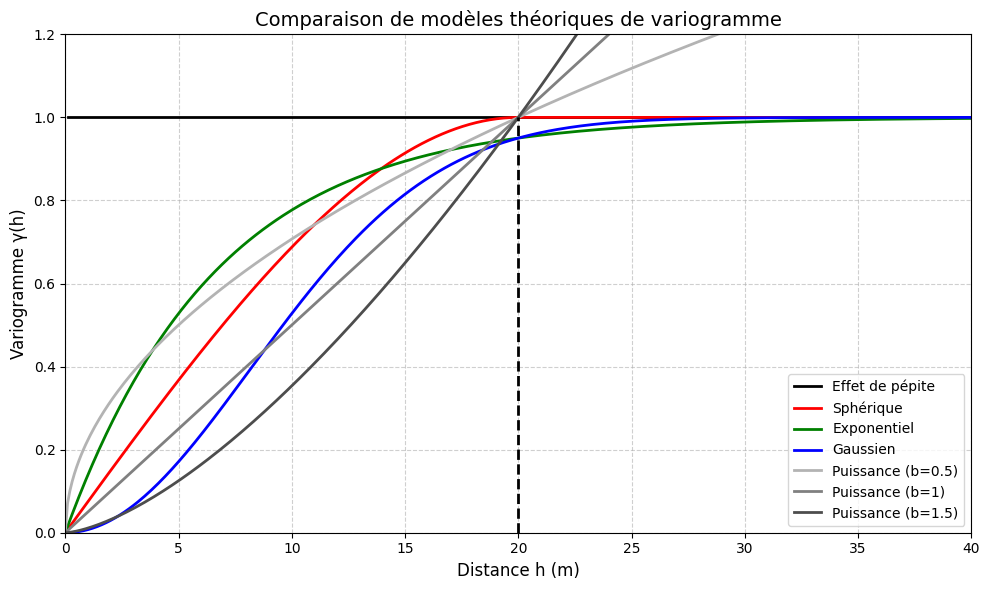

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Portée et palier
a = 20
C = 1

# Axe des distances
h = np.linspace(0, 40, 400)

# Modèles de variogramme
def nugget(h):
    return np.where(h == 0, 0, C)

def spherical(h):
    gamma = np.where(
        h < a,
        C * (1.5 * h / a - 0.5 * (h / a) ** 3),
        C
    )
    return gamma

def exponential(h):
    return C * (1 - np.exp(-3 * h / a))

def gaussian(h):
    return C * (1 - np.exp(-3 * (h / a) ** 2))

def power(h, b):
    return C * (h / a) ** b

# Création du graphique
plt.figure(figsize=(10, 6))

# Tracer des courbes
plt.plot(h[1:], nugget(h[1:]), 'k-', linewidth=2 , label="Effet de pépite")
plt.plot(h, spherical(h), 'r-', linewidth=2, label="Sphérique")
plt.plot(h, exponential(h), 'g-', linewidth=2, label="Exponentiel")
plt.plot(h, gaussian(h), 'b-', linewidth=2, label="Gaussien")

# Modèle puissance avec différentes valeurs de b
b_values = [0.5, 1, 1.5]
grayscale = ['0.7', '0.5', '0.3']
for b, color in zip(b_values, grayscale):
    label = f"Puissance (b={b})"
    plt.plot(h, power(h, b), color=color, linestyle='-', linewidth=2, label=label)

# Ligne verticale pleine pour l'effet de pépite de h=1 à h=40
plt.vlines(x=20, ymin=0, ymax=1, colors='black', linestyles='dashed', linewidth=2)

# Mise en forme du graphique
plt.xlabel("Distance h (m)", fontsize=12)
plt.ylabel("Variogramme γ(h)", fontsize=12)
plt.title("Comparaison de modèles théoriques de variogramme", fontsize=14)
plt.xlim(0, 40)
plt.ylim(0, 1.2)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



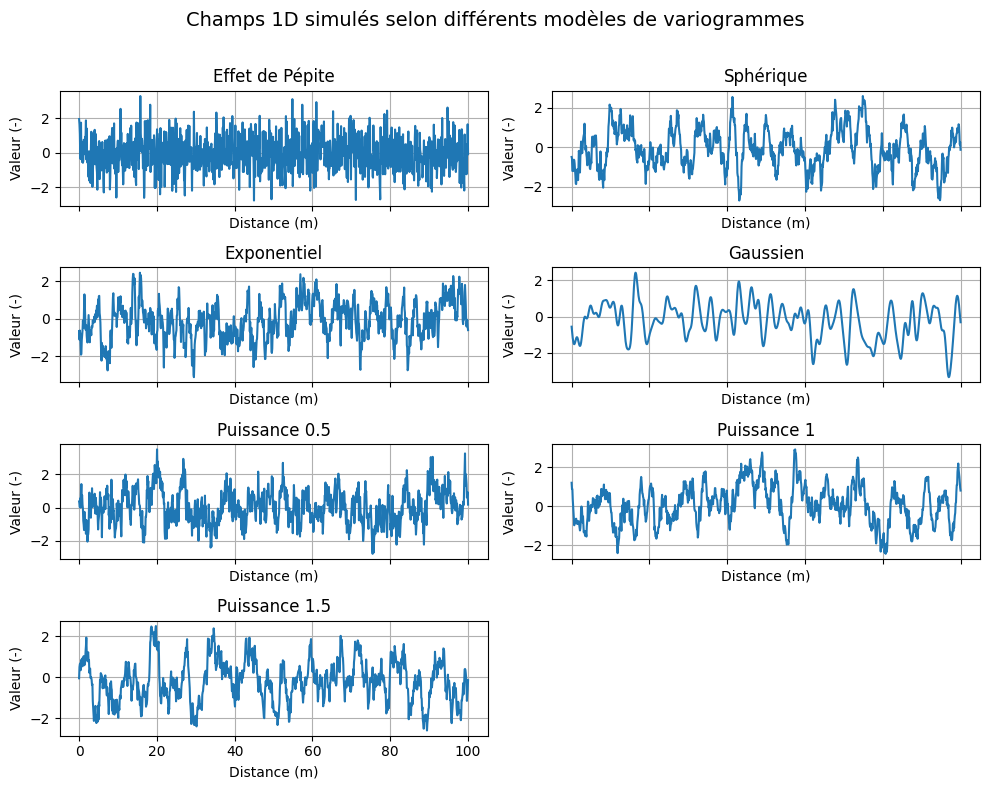

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftfreq

# Paramètres du champ
L = 100        # Longueur du champ (m)
n = 1024       # Nombre de points (puissance de 2 pour FFT)
dx = L / n     # Pas d'échantillonnage
x = np.linspace(0, L, n)

# Fonction de covariance à partir du variogramme
def cov_from_vario(vario_func, h):
    return 1 - vario_func(h)

# Définition des variogrammes théoriques (palier = 1, portée = 20)
a = 20
def nugget(h):
    return np.where(h == 0, 0, 1)

def spherical(h):
    hr = h / a
    return np.where(h < a, 1.5 * hr - 0.5 * hr**3, 1)

def exponential(h):
    return 1 - np.exp(-3 * h / a)

def gaussian(h):
    return 1 - np.exp(-3 * (h / a)**2)

def power(h, b):
    return np.minimum((h / a)**b, 1)

# Liste des modèles
models = {
    'Effet de Pépite': nugget,
    'Sphérique': spherical,
    'Exponentiel': exponential,
    'Gaussien': gaussian,
    'Puissance 0.5': lambda h: power(h, 0.5),
    'Puissance 1': lambda h: power(h, 1),
    'Puissance 1.5': lambda h: power(h, 1.5),
}

# Générer une réalisation avec FFT-MA
def simulate_fftma(vario_func):
    h = np.abs(np.fft.fftfreq(n, d=dx)) * L
    cov = cov_from_vario(vario_func, h)
    spectrum = np.sqrt(np.abs(fft(cov)))
    white_noise = np.random.normal(size=n)
    z_fft = spectrum * fft(white_noise)
    z = np.real(ifft(z_fft))
    return z / np.std(z)

# Générer tous les champs
fields = {name: simulate_fftma(f) for name, f in models.items()}

# Tracer les résultats dans une grille 4x2
fig, axs = plt.subplots(4, 2, figsize=(10, 8), sharex=True)
axs = axs.flatten()

for i, (name, z) in enumerate(fields.items()):
    axs[i].plot(x, z, label=name)
    axs[i].set_title(name)
    axs[i].grid(True)
    axs[i].set_xlabel("Distance (m)")
    axs[i].set_ylabel("Valeur (-)")

# Laisser le 8e emplacement vide
axs[-1].axis('off')
axs[-1].set_xlabel("")

fig.suptitle("Champs 1D simulés selon différents modèles de variogrammes", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()




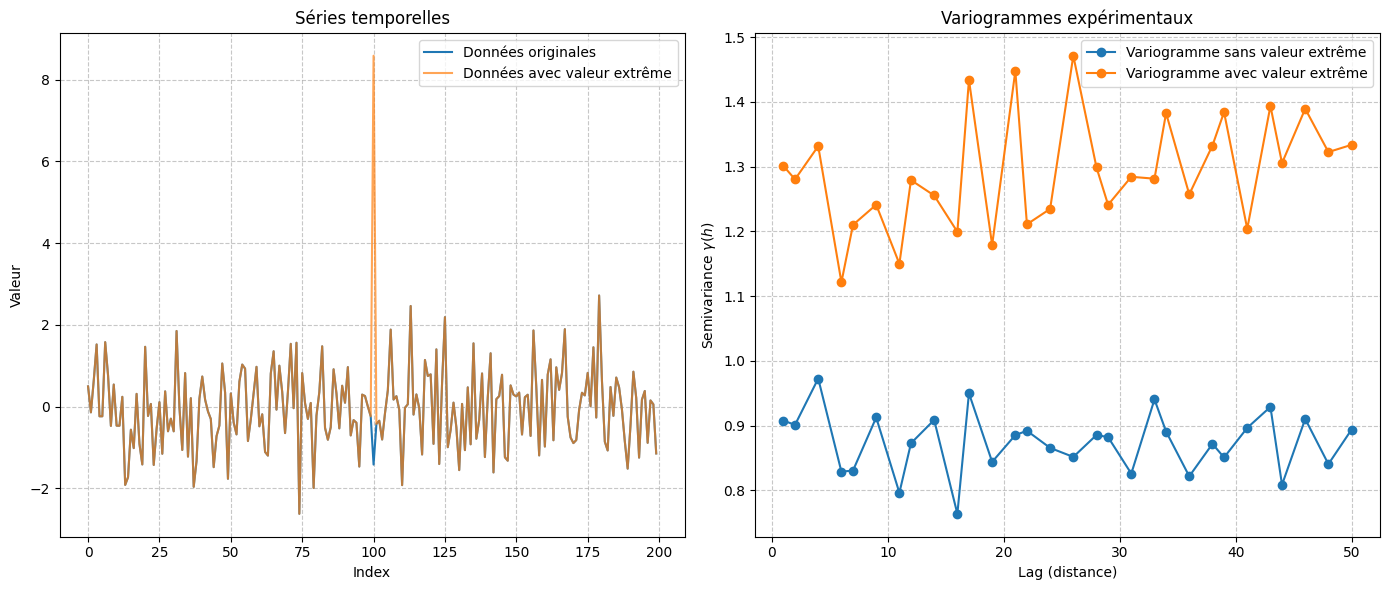

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def empirical_variogram(data, max_lag, n_lags):
    """
    Calcul du variogramme expérimental 1D par méthode classique.
    """
    lags = np.linspace(1, max_lag, n_lags, dtype=int)
    gamma = np.zeros_like(lags, dtype=float)

    n = len(data)
    for i, h in enumerate(lags):
        diffs = data[:-h] - data[h:]
        gamma[i] = 0.5 * np.mean(diffs**2)
    return lags, gamma

# Paramètres
np.random.seed(42)
n_points = 200
max_lag = 50
n_lags = 30

# Simulation d'un champ gaussien simple
data = np.random.normal(loc=0, scale=1, size=n_points)

# Ajout d'une valeur extrême ponctuelle (outlier)
data_with_outlier = data.copy()
data_with_outlier[100] += 10  # point extrême à l'indice 100

# Calcul variogrammes
lags, gamma = empirical_variogram(data, max_lag, n_lags)
lags_out, gamma_out = empirical_variogram(data_with_outlier, max_lag, n_lags)

# Création figure avec 2 sous-graphes côte à côte
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# À gauche : les deux séries superposées
axes[0].plot(data, label="Données originales")
axes[0].plot(data_with_outlier, label="Données avec valeur extrême", alpha=0.7)
axes[0].set_title("Séries temporelles")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Valeur")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.7)

# À droite : variogrammes expérimentaux superposés
axes[1].plot(lags, gamma, label="Variogramme sans valeur extrême", marker='o')
axes[1].plot(lags_out, gamma_out, label="Variogramme avec valeur extrême", marker='o')
axes[1].set_title("Variogrammes expérimentaux")
axes[1].set_xlabel("Lag (distance)")
axes[1].set_ylabel("Semivariance $\gamma(h)$")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
